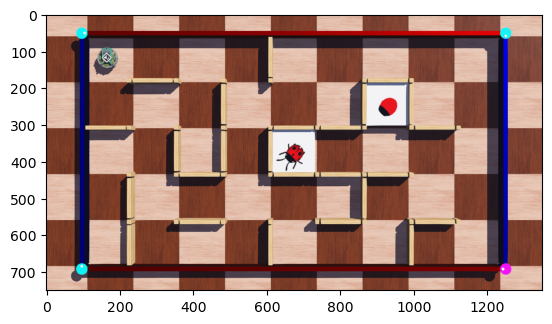

In [382]:
# notes: borrowed pixel position formula from https://www.geeksforgeeks.org/python-opencv-find-center-of-contour/
#3.1
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import math
import sys

IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME="../MapBuilt.txt"
MAZE_FILE_NAME="../Maze.png"
ROBOT_FILE_NAME="../Robot.png"
img_maze = cv2.imread(MAZE_FILE_NAME)
mazeHSV = cv2.cvtColor(img_maze,cv2.COLOR_BGR2HSV)
mazeRGB = cv2.cvtColor(img_maze,cv2.COLOR_BGR2RGB)
# bug=cv2.imread("../Ladybug_small.png")
# bugRGB = cv2.cvtColor(bug,cv2.COLOR_BGR2RGB)
bot=cv2.imread(ROBOT_FILE_NAME)
botRGB = cv2.cvtColor(bot,cv2.COLOR_BGR2RGB)
plt.imshow(mazeRGB)
plt.show()
# plt.imshow(bugRGB)
# plt.show()
# plt.imshow(botRGB)
# plt.show()

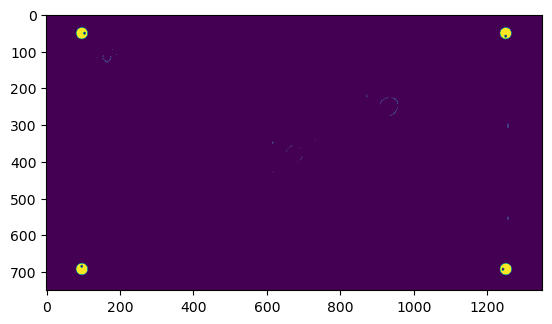

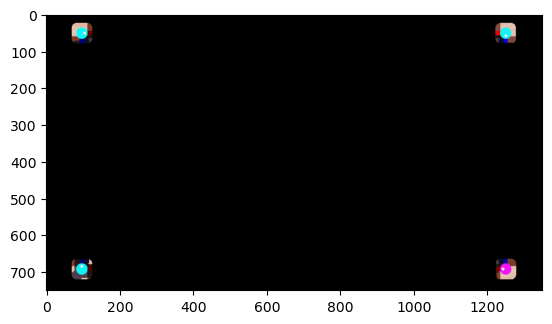

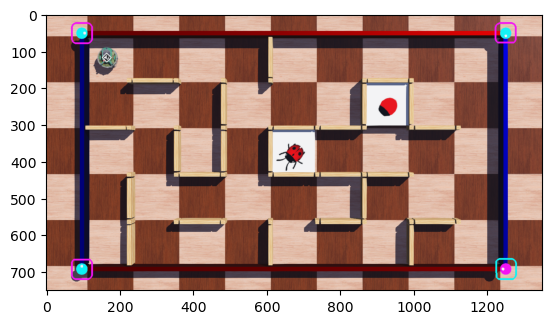

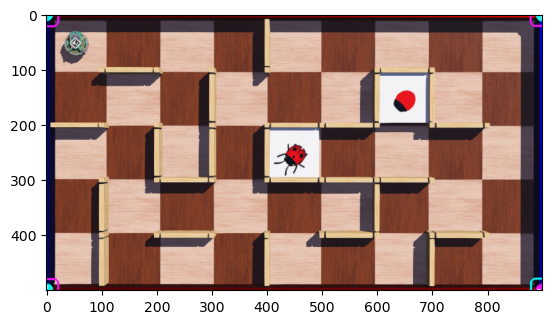

In [383]:
#3.2 & 3.3
#helper func to find pink corner
#assuming that only 1 corner will ever be overexposed based on the given world
def findCorner(mazeHSV,dil):
    contours,hier=cv2.findContours(dil,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    br=np.float32([-1,-1])
    for i in contours: 
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            color=mazeHSV[cy,cx]
            if color[0]>100:
                cv2.drawContours(mazeRGB, [i], -1, (12, 243,245), 3)
                br[0]=cx
                br[1]=cy
                white==True
                return br
            elif color[0]==0 and color[1]==0 and color[2]>250:
                if white==True:
                    continue 
                cv2.drawContours(mazeRGB, [i], -1, (12, 243,245), 3)
                dil = cv2.circle(dil, (int(cx),int(cy)), 50, (0,0,0), -1)
                br[0]=cx
                br[1]=cy
                white==True
                return br

white=False
#mask corners
maskc=cv2.inRange(mazeHSV,(90,0,170),(100,250,255))
maskp=cv2.inRange(mazeHSV,(140,0,170),(170,240,255))
mask=cv2.bitwise_or(maskc,maskp)
plt.imshow(mask)
plt.show()
kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
kernel1 = np.ones((3,3), np.uint8)
opening = cv2.erode(opening, kernel1,iterations=3) 
dil=cv2.dilate(opening, kernel, iterations=8)

masking=cv2.bitwise_and(mazeRGB, mazeRGB, mask=dil)
plt.imshow(masking)
plt.show()

# get coordinates of pink corner
br=findCorner(mazeHSV,dil)
# masking=cv2.bitwise_and(mazeRGB, mazeRGB, mask=dil)
# plt.imshow(masking)
# plt.show()
while br[0]<1012.5 and br[1]<375:
    mazeHSV=cv2.rotate(mazeHSV, cv2.cv2.ROTATE_180)
    mazeRGB=cv2.rotate(mazeRGB, cv2.cv2.ROTATE_180)
    dil=cv2.rotate(dil, cv2.cv2.ROTATE_180)
    br=findCorner(mazeHSV,dil)
      
# plt.imshow(dil)
# plt.show()

# get coordinates of blue corners
contours,hier=cv2.findContours(dil,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
tl=np.float32([-1,-1])
bl=np.float32([-1,-1])
tr=np.float32([-1,-1])
dist=0;
temp=[]
idx=0

for i in contours: 
    M = cv2.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        color=mazeHSV[cy,cx]
        if color[0]>100:
            continue
        else:
            cv2.drawContours(mazeRGB, [i], -1, (243, 20, 245), 3)
            temp.append((cx,cy))
plt.imshow(mazeRGB)
plt.show()

# assign blue corners
for i in temp:
    if i[0]<=337.5 and i[1]<=375:
        tl[0]=i[0]
        tl[1]=i[1]
    elif i[0]<=337.5 and i[1]>=375:
        bl[0]=i[0]
        bl[1]=i[1]
    elif i[0]>=1012.5 and i[1]<=375:
        tr[0]=i[0]
        tr[1]=i[1]

# transform maze
pt1=np.float32([tl,tr,bl,br])
pt2=np.float32([[0,0],[900,0],[0,500],[900,500]])
h=cv2.getPerspectiveTransform(pt1,pt2)
mazeRGBc=cv2.warpPerspective(mazeRGB,h,(900,500))
mazeHSVc=cv2.warpPerspective(mazeHSV,h,(900,500))
plt.imshow(mazeRGBc)
plt.show()

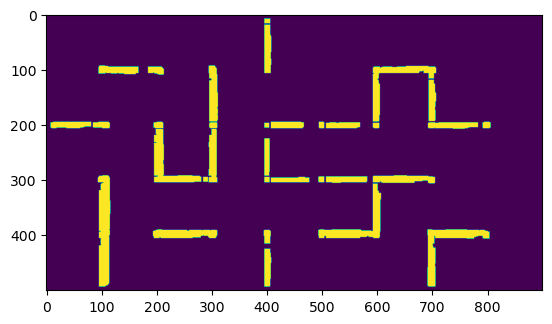

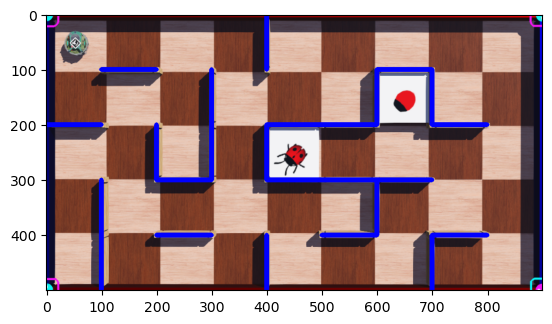

In [384]:
#3.4
# blurring to blend wall colour together
blur = cv2.GaussianBlur(mazeHSVc, (5, 5), cv2.BORDER_DEFAULT)
mask=cv2.inRange(blur,(13,80,90),(40,120,255))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
# masking=cv2.bitwise_and(mazeRGBc, mazeRGBc, mask=opening)
# plt.imshow(masking)
# plt.show()
kernel1 = np.ones((3,3), np.uint8)
mask = cv2.erode(opening, kernel1,iterations=1) 
mask=cv2.dilate(opening, kernel, iterations=1)
plt.imshow(mask)
plt.show()

# search for detected walls in mask
hori=[[0 for i in range(9)] for j in range(6)]
vert=[[0 for i in range(10)] for j in range(5)]

# horizontal wall
for i in range(6):
    for j in range(9):
        x=i*100
        y=j*100+50
        if i==0 or i==5:
            hori[i][j]=1
        elif mask[x][y]!=0:
#             if mask[x][y-20]!=0 and mask[x][y+20]!=0:
            hori[i][j]=1
            cv2.line(mazeRGBc, (y-50, x), (y+50, x), (0, 0, 255), 8)

# vertical wall               
for i in range(5):
    for j in range(10):
        x=i*100+50
        y=j*100
        if j==0 or j==9:
            vert[i][j]=1
        elif mask[x][y]!=0:
#             if mask[x][y-10]!=0 and mask[x][y+10]!=0:
            vert[i][j]=1
            cv2.line(mazeRGBc, (y, x-50), (y, x+50), (0, 0, 255), 8)

plt.imshow(mazeRGBc)
plt.show()

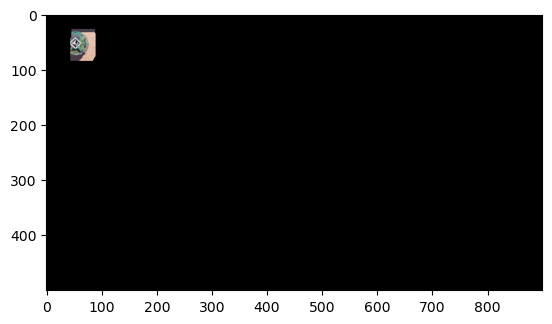

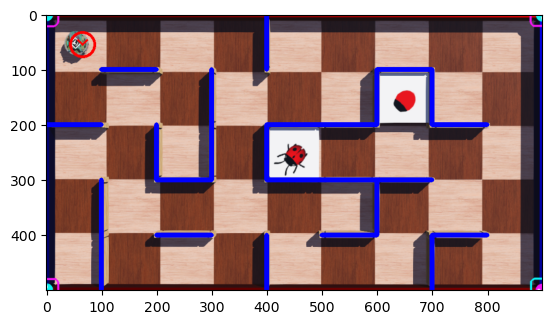

In [385]:
#3.5
# masking to find robot
mask1=cv2.inRange(blur,(35,1,30),(107,195,245))
mask1 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, kernel)
mask1 = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, kernel)
mask1=cv2.erode(mask1, kernel, iterations=3)
mask1=cv2.dilate(mask1, kernel, iterations=10)
# plt.imshow(mask1)
# plt.show()
bot=cv2.bitwise_and(mazeRGBc, mazeRGBc, mask=mask1)
plt.imshow(bot)
plt.show()

# getting coordinates of bot
cx=0
cy=0
posx=0
posy=0
contours,hier=cv2.findContours(mask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
M = cv2.moments(contours[0])
if M['m00'] != 0:
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    mazeRGBc = cv2.circle(mazeRGBc, (int(cx),int(cy)), 22, (255,0,0), 3)   
    posy=math.floor(cx/100)
    posx=math.floor(cy/100)

# finding bot heading
heading=''
dictionary=cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
param=cv2.aruco.DetectorParameters_create()
markerCorners, markerIds,_ = cv2.aruco.detectMarkers(botRGB, dictionary, parameters=param)
cv2.aruco.drawDetectedMarkers(botRGB,markerCorners,markerIds)
corners=markerCorners[0][0]
# first one is blue square one
ref=corners[0]
x=sorted(corners,key=lambda i:i[0])
y=sorted(corners,key=lambda i:i[1])

if(ref==x[0]).all():
    heading='w'
    cv2.line(mazeRGBc, (cx, cy), (cx+8, cy-8), (255, 0, 0), 3)
    cv2.line(mazeRGBc, (cx, cy), (cx+8, cy+8), (255, 0, 0), 3)
elif(ref==x[3]).all():
    heading='e'
    cv2.line(mazeRGBc, (cx, cy), (cx-8, cy-8), (255, 0, 0), 3)
    cv2.line(mazeRGBc, (cx, cy), (cx-8, cy+8), (255, 0, 0), 3)
elif(ref==y[0]).all():
    heading='n'
    cv2.line(mazeRGBc, (cx, cy), (cx-8, cy+8), (255, 0, 0), 3)
    cv2.line(mazeRGBc, (cx, cy), (cx+8, cy+8), (255, 0, 0), 3)
elif(ref==y[3]).all():
    heading='s'
    cv2.line(mazeRGBc, (cx, cy), (cx-8, cy-8), (255, 0, 0), 3)
    cv2.line(mazeRGBc, (cx, cy), (cx+8, cy-8), (255, 0, 0), 3)
plt.imshow(mazeRGBc)
plt.show()

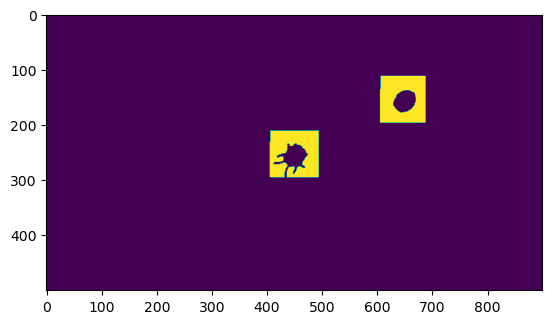

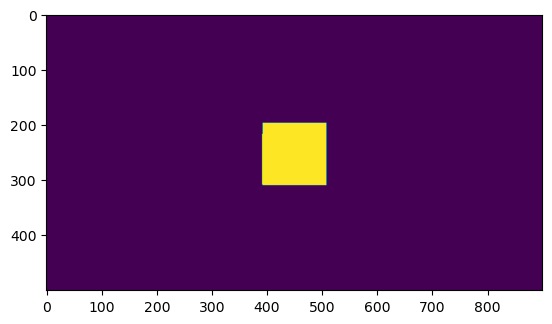

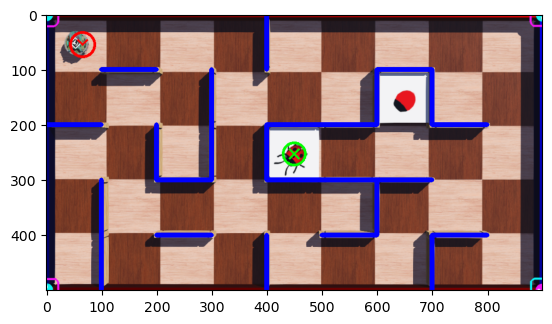

In [386]:
#3.6
# mask for white square
mask=cv2.inRange(mazeHSVc,(100,0,220),(170,120,255))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
plt.imshow(mask)
plt.show()

# detect fake target
params=cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 2
params.filterByCircularity = True
params.minCircularity = 0.1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(mask)
x = keypoints[0].pt[0]
y = keypoints[0].pt[1]

# remove fake target
mask = cv2.circle(mask, (int(x),int(y)), 50, (0,0,0), -1)
mask=cv2.dilate(mask, kernel, iterations=1)
mask=cv2.erode(mask, kernel, iterations=4)
mask=cv2.dilate(mask, kernel, iterations=10)
plt.imshow(mask)
plt.show()

# find pos of true target
contours,hier=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
tagx=0
tagy=0
for i in contours:
    M = cv2.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        tagy=math.floor(cx/100)
        tagx=math.floor(cy/100)
        mazeRGBc = cv2.circle(mazeRGBc, (int(cx),int(cy)), 20, (0,255,0), 3)
        cv2.line(mazeRGBc, (cx, cy), (cx-8, cy-8), (0, 255, 0), 3)
        cv2.line(mazeRGBc, (cx, cy), (cx-8, cy+8), (0, 255, 0), 3)
        cv2.line(mazeRGBc, (cx, cy), (cx+8, cy-8), (0, 255, 0), 3)
        cv2.line(mazeRGBc, (cx, cy), (cx+8, cy+8), (0, 255, 0), 3)

plt.imshow(mazeRGBc)
plt.show()

In [387]:
#3.7
# write rows and cols in one loop
with open(MAP_FILE_NAME,'w') as f:
    for i in range(6):
        row=''
        col=''   
        for j in range(10):
            if j<9:
                if hori[i][j]==1:
                    row+=' ---'
                else:
                    row+='    '
            if i<5:
                if vert[i][j]==1:
                    col+='|'
                else:
                    col+=' '
                if i==posx and j==posy:
                    if heading=='n':
                        col+=' ^ '
                    elif heading=='s':
                        col+=' v '
                    elif heading=='e':
                        col+=' > '
                    elif heading=='w':
                        col+=' < '
                elif i==tagx and j==tagy:
                    col+=' x '
                else:
                    col+='   '
        f.write(row)
        print(row)
        f.write("\n")
        f.write(col)
        print(col)
        f.write("\n")
    f.close()

 --- --- --- --- --- --- --- --- ---
| v             |                   |   
     ---                 ---        
|           |           |   |       |   
 ---             --- ---     ---    
|       |   |   | x                 |   
         ---     --- --- ---        
|   |                   |           |   
         ---         ---     ---    
|   |           |           |       |   
 --- --- --- --- --- --- --- --- ---

